# NicheVI for representing cells and their environment in spatial transcriptomics
In this tutorial, we go through the steps of training NicheVI, a deep generative model that leverages both cell-intrinsic and neighboring gene expression profiles to produce stochastic embeddings of cell states as well as normalized gene expression profiles. We show how to obtain informative fine-grained partitions of cells that reflects both their internal state and the surrounding tissue and use the generative model to test hypotheses of differential expression between tissue niches.

Plan for this tutorial:

1. Loading the data
2. Training a NicheVI model
3. Visualizing the latent space
4. Perform DE analysis across niches

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install from GitHub for now
!pip install --quiet scvi-colab
!pip install --quiet adjustText
from scvi_colab import install

install()

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [3]:
import os
import tempfile

import numpy as np  # type: ignore
import scanpy as sc  # type: ignore
import scvi  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Impor

Last run with scvi-tools version: 1.3.0

In [4]:
# Quickly check the correct folder is used.
scvi.__file__

'/home/nathanl/scvi-tools-main/src/scvi/__init__.py'

## Data loading

In this tutorial we load a human breast cancer section, generated with [10X Xenium](https://www.nature.com/articles/s41467-023-43458-x). 
The cell segmentation originally performed on this data resulted in many erroneously assigned transcripts and therefore re-segmented the cells using the [ProSeg](https://www.biorxiv.org/content/10.1101/2024.04.25.591218v1) algorithm, which is a scalable algorithm for transcriptome-informed segmentation.

In [5]:
adata_path = os.path.join(save_dir.name, "xenium_tutorial.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/53178338",
)
adata

  0%|          | 0.00/1.11G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 117305 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 'cell_type'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca'
    obsm: 'X_pca', 'X_scANVI', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'

The authors identified distinct tumor domains in this specimen, corresponding to in situ ductal carcinoma (DCIS) and invasive tumor:

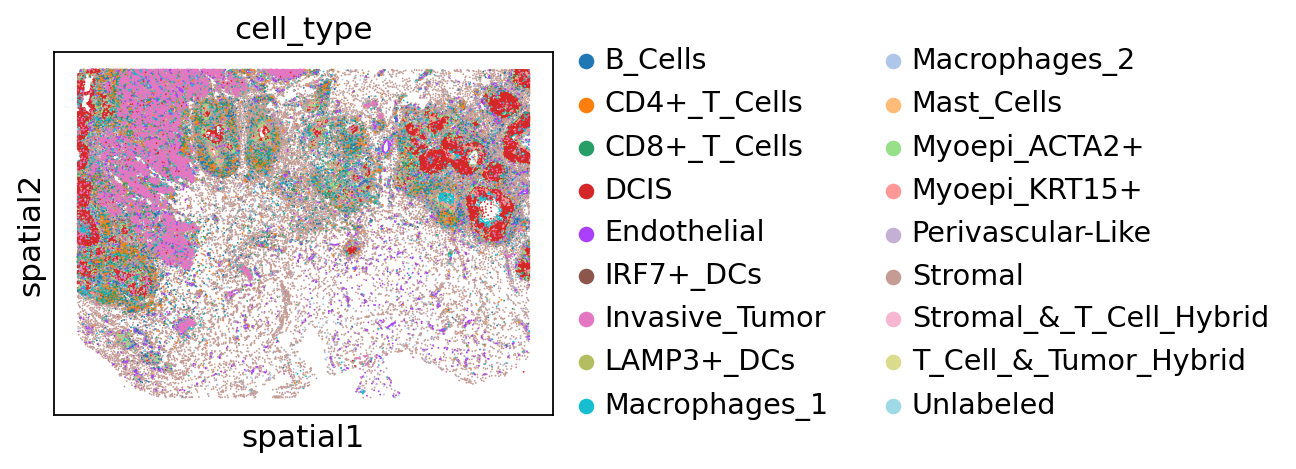

In [6]:
sc.pl.spatial(adata, color="cell_type", spot_size=30)

In [7]:
adata.obs["cell_type"].value_counts()

cell_type
Stromal                    32426
Invasive_Tumor             18185
DCIS                       15993
CD4+_T_Cells                9387
Macrophages_1               8644
CD8+_T_Cells                7493
Endothelial                 7000
B_Cells                     5359
Myoepi_ACTA2+               5324
Myoepi_KRT15+               2636
Macrophages_2               2616
Perivascular-Like            817
Unlabeled                    516
IRF7+_DCs                    454
LAMP3+_DCs                   218
Mast_Cells                   203
Stromal_&_T_Cell_Hybrid       28
T_Cell_&_Tumor_Hybrid          6
Name: count, dtype: int64

## Train NicheVI model

We first define the neighborhood of each cell using a k-nn graph. We set $k=20$. Then, the environment features are defined in two ways - the first is the cell-type composition of its cellular neighborhood. The second is the average gene expression state of neighboring cells, with a separate profile for each of the present cell types. These cell-intrinsic gene expression states are learned with a spatially unaware model, which needs to be trained first.

Here we assume that scANVI has already been trained on the data, and that the embeddings are stored in the AnnData object. We refer to the scANVI tutorial for training the model.


Environment features computations occur in the `preprocessing_anndata` method, that adds the relevant keys to the AnnData object. 

In [8]:
setup_kwargs = {
    "sample_key": "sample",  # specify column in adata.obs that contains the individual slide ID
    "labels_key": "cell_type",  # specify column in adata.obs that contains the cell type labels
    "cell_coordinates_key": "spatial",  # specify key in adata.obsm that contains the spatial coordinates
    "expression_embedding_key": "X_scANVI",  # specify key in adata.obsm that contains the expression embedding
}

In [9]:
scvi.external.nicheSCVI.preprocessing_anndata(
    adata,
    k_nn=20,  # number of nearest neighbors for spatial graph construction
    **setup_kwargs,
)

Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

Saved niche_activation in adata.obsm

Then, as in all scvi-tools model, we need to register the AnnData.

In [10]:
scvi.external.nicheSCVI.setup_anndata(
    adata,
    layer="counts",  # specify layer in adata that contains the raw counts
    batch_key="sample",  # specify column in adata.obs that contains the batch covariate to correct for
    **setup_kwargs,
)

INFO     Using column names from columns of adata.obsm['niche_composition']                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


We instantiate a NicheVI model:

In [11]:
nichevae = scvi.external.nicheSCVI(
    adata
)

nichevae

nicheVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [12]:
nichevae.train(
    max_epochs=200,
    early_stopping=True,
    check_val_every_n_epoch=1,
    batch_size=512,
    plan_kwargs={
        "lr": 5e-4,
    },
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


We can plot the training curves:

In [13]:
nichevae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'niche_compo_validation', 'niche_reconst_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_compo_train', 'niche_reconst_train'])

Let's plot for instance the validation ELBO, niche composition and state losses:

<Axes: xlabel='epoch'>

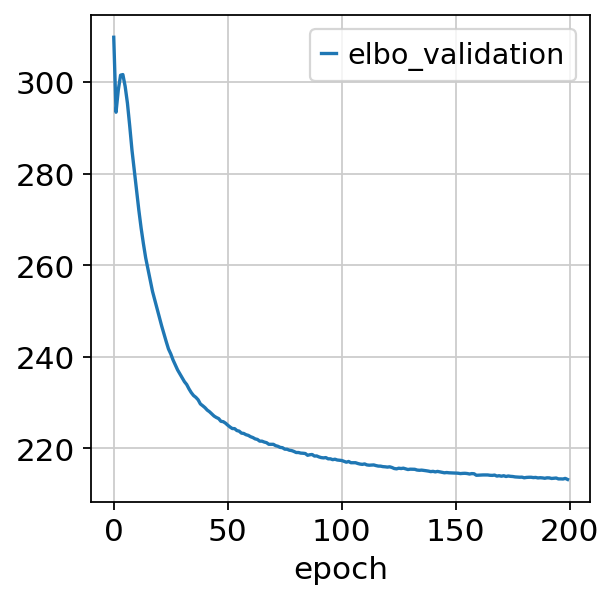

In [14]:
nichevae.history["elbo_validation"].plot()

<Axes: xlabel='epoch'>

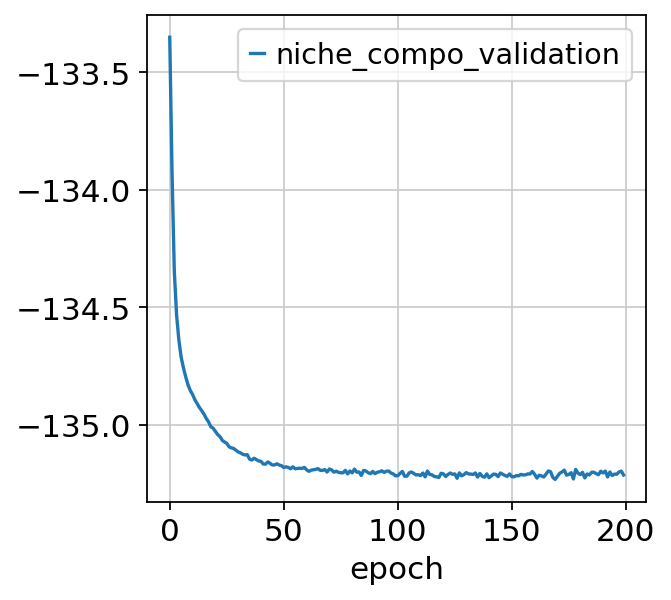

In [15]:
nichevae.history["niche_compo_validation"].plot()

<Axes: xlabel='epoch'>

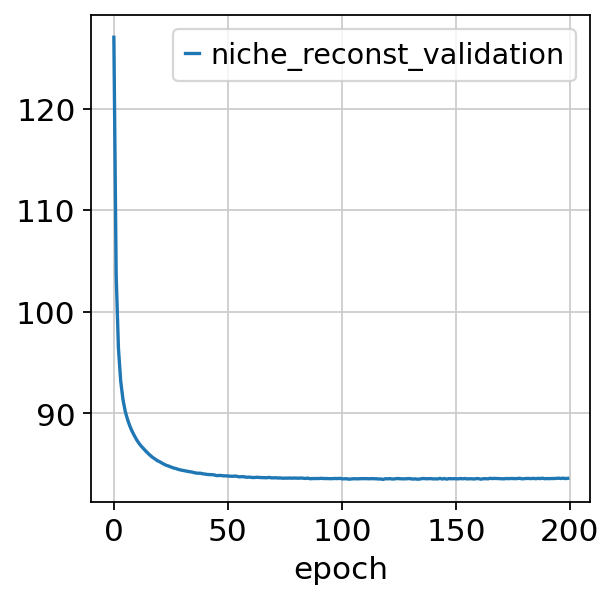

In [16]:
nichevae.history["niche_reconst_validation"].plot()

After training the model, we can compute and store the latent space: 

In [17]:
adata.obsm["X_nicheVI"] = nichevae.get_latent_representation()

We may visualize the latent space in UMAP coordinates, coloring by cell type. 

In [18]:
# sc.pp.neighbors(adata, use_rep="X_nicheVI", n_neighbors=30)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color="cell_type", frameon=False)

# Differential expression analysis

We now use the generative model to test hypotheses of differential expression between the niches. We'll focus on endothelial cells. 

In [19]:
adata_endothelial = adata[adata.obs["cell_type"] == "Endothelial"].copy()
adata_not_endo = adata[adata.obs["cell_type"] != "Endothelial"].copy()

print(adata_endothelial)

AnnData object with n_obs × n_vars = 7000 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 
'cell_type', '_scvi_batch', '_scvi_labels', '_scvi_sample'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca', 'cell_type_colors'
    obsm: 'X_pca', 'X_scANVI', 'spatial', 'niche_indexes', 'niche_distances', 'niche_composition', 
'niche_activation', 'X_nicheVI'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'

We perform coarse Leiden clustering on the endothelial latent space, in a bid to find spatially confined populations of endothelial cells.

In [20]:
sc.pp.neighbors(adata_endothelial, use_rep="X_nicheVI", n_neighbors=30, random_state=42)
sc.tl.umap(adata_endothelial)
sc.tl.leiden(
    adata_endothelial,
    key_added="leiden_nicheVI",
    resolution=0.3,
    flavor="igraph",
    n_iterations=-1,
    random_state=42,
)

In [21]:
adata_endothelial.obs["leiden_nicheVI"].unique()  # check the number of clusters

['0', '3', '1', '2', '4']
Categories (5, object): ['0', '1', '2', '3', '4']

We focus on clusters 0 and 1, which are located in the stromal and tumor regions, respectively. We then perform differential expression analysis between these two clusters.

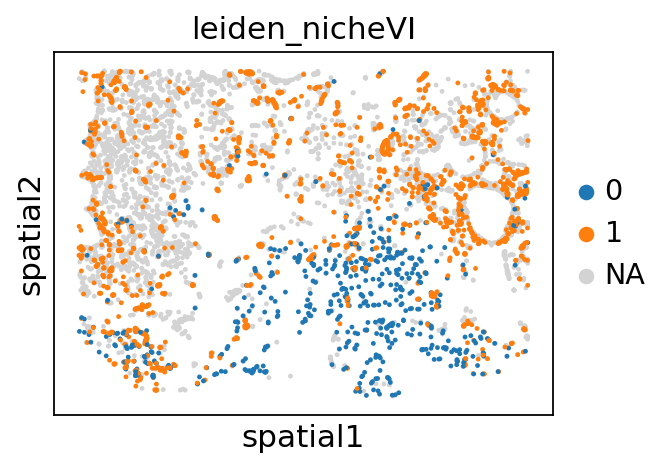

In [22]:
sc.pl.spatial(
    adata_endothelial,
    color="leiden_nicheVI",
    spot_size=80,
    groups=["1", "0"],
)

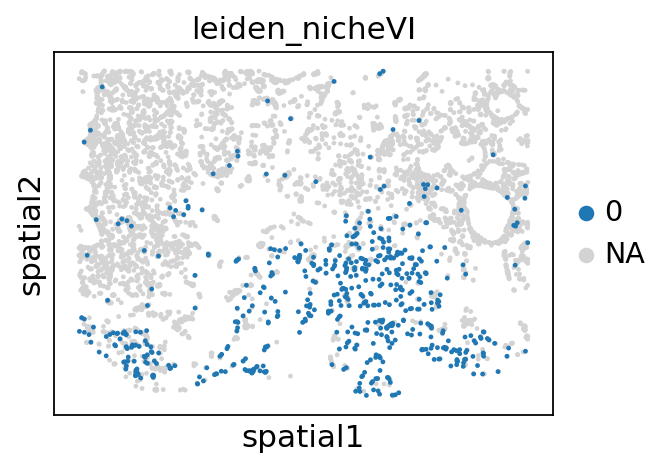

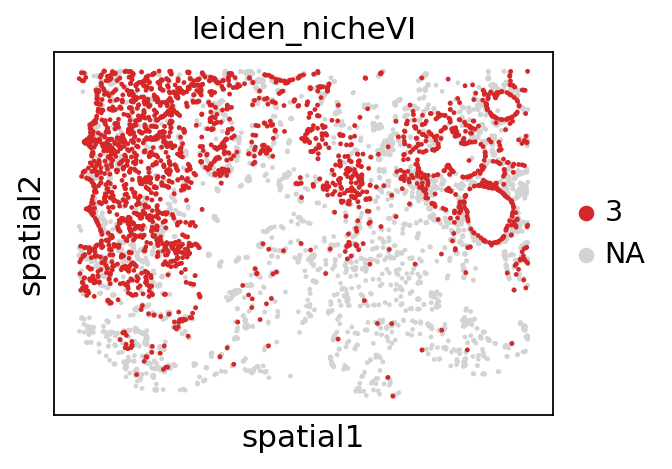

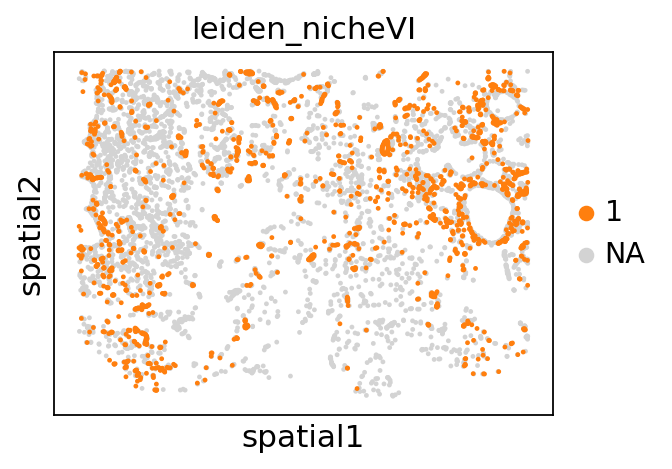

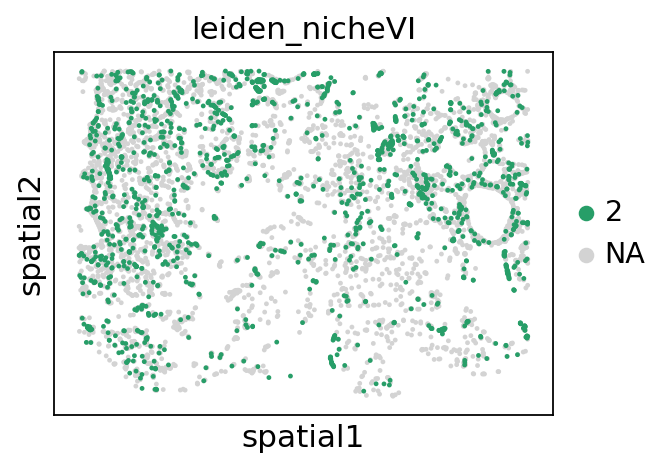

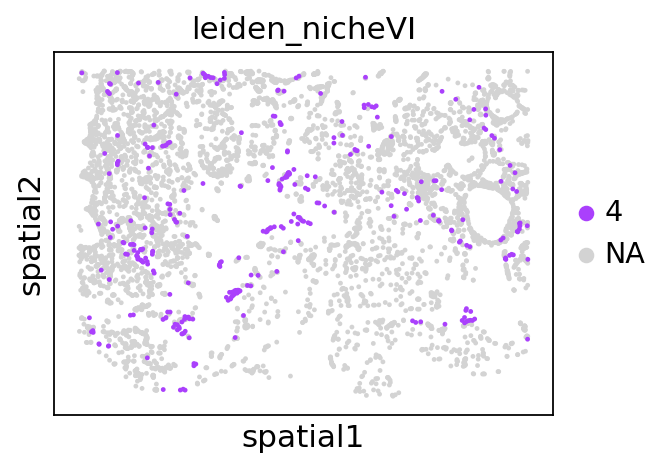

In [23]:
for cluster in adata_endothelial.obs["leiden_nicheVI"].unique():
    sc.pl.spatial(adata_endothelial, color="leiden_nicheVI", spot_size=80, groups=[cluster])

In [24]:
sc.tl.rank_genes_groups(adata_endothelial, groupby="leiden_nicheVI", method="wilcoxon")
marker_dicts = {
    group: sc.get.rank_genes_groups_df(adata_endothelial, group=group).head(20)["names"].tolist()
    for group in adata_endothelial.obs["leiden_nicheVI"].unique()
}
marker_dicts
# sc.pl.rank_genes_groups_df(adata_endothelial, n_genes=20, ncols=5)

{'0': ['ADH1B',
  'BTNL9',
  'PDK4',
  'LPL',
  'CAVIN2',
  'TIMP4',
  'ADIPOQ',
  'CLDN5',
  'PPARG',
  'AKR1C1',
  'CCDC80',
  'NOSTRIN',
  'CD14',
  'CD163',
  'HOXD9',
  'FGL2',
  'RAPGEF3',
  'IGF1',
  'MRC1',
  'SFRP1'],
 '3': ['KDR',
  'BTNL9',
  'ESM1',
  'TCIM',
  'ZEB1',
  'CLEC14A',
  'RAMP2',
  'MMP2',
  'CCND1',
  'JUP',
  'PRDM1',
  'EDNRB',
  'LUM',
  'POSTN',
  'TCF4',
  'SNAI1',
  'VOPP1',
  'SVIL',
  'CD93',
  'CDC42EP1'],
 '1': ['VWF',
  'AQP1',
  'PECAM1',
  'BACE2',
  'FLNB',
  'EDN1',
  'NOSTRIN',
  'MMRN2',
  'SERPINA3',
  'PDK4',
  'PTGDS',
  'CD93',
  'ANKRD29',
  'IL3RA',
  'DSP',
  'CAVIN2',
  'WARS',
  'RAPGEF3',
  'ALDH1A3',
  'TOMM7'],
 '2': ['ACTA2',
  'CAV1',
  'ZEB2',
  'MYLK',
  'PDGFRB',
  'FBLIM1',
  'AVPR1A',
  'DST',
  'CXCL12',
  'LGALSL',
  'MYH11',
  'S100A4',
  'RUNX1',
  'PELI1',
  'ADGRE5',
  'CRISPLD2',
  'ACTG2',
  'ANKRD29',
  'MEDAG',
  'SOX17'],
 '4': ['MRC1',
  'CAVIN2',
  'FAM107B',
  'IGF1',
  'ANGPT2',
  'CD9',
  'CCND1',
  'WARS',
 

In [25]:
adata.obs["leiden_nicheVI"] = "Unknown"
adata.obs.loc[adata.obs["cell_type"] == "Endothelial", "leiden_nicheVI"] = adata_endothelial.obs[
    "leiden_nicheVI"
]

In [26]:
adata.obs["leiden_nicheVI"].value_counts()

leiden_nicheVI
Unknown    110305
3            2509
1            1941
2            1634
0             588
4             328
Name: count, dtype: int64

We now run the differential expression function, between the nichetypes $\textit{G1}=tumor~endothelial$ and $\textit{G2}=stromal~endothelial$. We first set the number of nearest neighbors to compute the non-endothelial neighbors of $\textit{G1}$ and $\textit{G2}$, called $\textit{N1}$ and $\textit{N2}$, respectively. 

Setting `niche_mode=True`, we compute 4 different DE tests:  $\{\textit{G1}~vs~\textit{G2}\}$,  $\{\textit{G1}~vs~\textit{N1}\}$,  $\{\textit{N1}~vs~\textit{G2}\}$ and $\{\textit{N1}~vs~\textit{N2}\}$ (in this order). We set a test-specific treshold for significant log-fold change `DELTA`. 

Other parameters include the number of samples to draw from the posterior `N_SAMPLES_DE`, `PSEUDOCOUNTS` for stability and `FDR` for the FDR correction. More details can be found in Boyeau et al. PNAS 2023.




In [27]:
# del adata.uns["adjusted_A"]

In [28]:
delta_niches = 0.05 #smaller delta for niche comparison
delta_markers = 0.15 #bigger delta for G1-N1 comparison
DELTA = [delta_niches, delta_markers, delta_niches, delta_niches]


K_NN_DE = 6

GROUP = "leiden_nicheVI"
G1 = "1"
G2 = "0"
PSEUDOCOUNTS = 1e-4
N_SAMPLES_DE = 1e5
FDR = 0.2

DE_1_0 = nichevae.differential_expression(
    adata,
    groupby=GROUP,
    group1=G1,
    group2=G2,
    k_nn=K_NN_DE,
    delta=DELTA,
    niche_mode=True,
    n_samples_overall=N_SAMPLES_DE,
    fdr_target=FDR,
    pseudocounts=PSEUDOCOUNTS,
)

Computing adjusted nearest neighbors...

Using 1 samples

Mean number of neighbors: 3.3 ± 2.1

Computing DE...

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Running DE for group1_group2

100%|██████████| 1/1 [00:00<00:00, 383.99it/s]


Running DE for group1_neighbors1

100%|██████████| 1/1 [00:00<00:00, 669.48it/s]


Running DE for neighbors1_group2

100%|██████████| 1/1 [00:00<00:00, 399.53it/s]


Running DE for neighbors1_neighbors2

100%|██████████| 1/1 [00:00<00:00, 572.76it/s]


Computing g1 confidence scores...

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Let's analysize the DE test: $\textit{G1}=tumor~endothelial$ vs $\textit{G2}=stromal~endothelial$. The DE function returns a Dataclass object `DE_1_0`. 

We can access the Gaussian process classifier properties with the `gpc` attribute: 

In [29]:
DE_1_0.gpc

GaussianProcessClassifier(kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=10),
                          n_restarts_optimizer=10, random_state=0)

In [30]:
DE_1_0.gpc_info()

Training score:  0.9440559440559441

Marginal likelihood:  -23.43938448798275

Kernel:  31.6**2 * RationalQuadratic(alpha=0.119, length_scale=10)

The $\textit{G1}$ vs $\textit{G2}$ differential expression results are stored in the `g1_g2` attribute: 

In [31]:
DE_1_0.g1_g2

proba_de  proba_not_de  bayes_factor    scale1    scale2   
TIMP4      0.96235       0.03765     -3.241045  0.000570  0.005237  \
BTNL9      0.95245       0.04755     -2.997256  0.003491  0.021826   
SERPINA3   0.94301       0.05699      2.806201  0.009894  0.002322   
LEP        0.93928       0.06072     -2.738840  0.000140  0.002329   
ADIPOQ     0.93502       0.06498     -2.666488  0.000713  0.009480   
...            ...           ...           ...       ...       ...   
CCL20      0.46587       0.53413      0.136733  0.000049  0.000050   
HPX        0.46216       0.53784      0.151650  0.000123  0.000123   
C2orf42    0.45097       0.54903      0.196752  0.000621  0.000627   
MDM2       0.45044       0.54956      0.198893  0.005288  0.005210   
DAPK3      0.43991       0.56009      0.241527  0.000708  0.000700   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean2   
TIMP4           0.0001   0.05 -3.087659   -3.110143  1.688342  ...   2.193878  \
BTNL9           0.0001   0.05 -3.047562   -3.115764  1.711292  ...   7.127551   
SERPINA3        0.0001   0.05  1.972647    1.976313  1.204642  ...   0.353741   
LEP             0.0001   0.05 -3.196130   -3.117663  2.105543  ...   0.613946   
ADIPOQ          0.0001   0.05 -3.455118   -3.511446  2.190399  ...   3.369048   
...                ...    ...       ...         ...       ...  ...        ...   
CCL20           0.0001   0.05 -0.075217   -0.097155  0.954491  ...   0.015306   
HPX             0.0001   0.05 -0.024112   -0.041067  0.609190  ...   0.017007   
C2orf42         0.0001   0.05 -0.013719   -0.014743  0.355862  ...   0.178571   
MDM2            0.0001   0.05  0.013353   -0.001801  0.407200  ...   1.532313   
DAPK3           0.0001   0.05  0.002393   -0.011559  0.317723  ...   0.132653   

          non_zeros_proportion1  non_zeros_proportion2  raw_normalized_mean1   
TIMP4                  0.063369               0.491497              4.603941  \
BTNL9                  0.159711               0.840136             27.313246   
SERPINA3               0.422978               0.175170            101.111283   
LEP                    0.007728               0.180272              0.432612   
ADIPOQ                 0.017002               0.389456              1.574924   
...                         ...                    ...                   ...   
CCL20                  0.004637               0.013605              0.194030   
HPX                    0.020093               0.017007              1.059498   
C2orf42                0.117465               0.151361              6.298750   
MDM2                   0.485832               0.532313             58.011363   
DAPK3                  0.109737               0.108844              6.670252   

          raw_normalized_mean2  is_de_fdr_0.2  comparison  group1  group2   
TIMP4                74.504753           True      1 vs 0       1       0  \
BTNL9               281.164435           True      1 vs 0       1       0   
SERPINA3             10.847361           True      1 vs 0       1       0   
LEP                  19.287606           True      1 vs 0       1       0   
ADIPOQ               92.395446           True      1 vs 0       1       0   
...                        ...            ...         ...     ...     ...   
CCL20                 0.401855          False      1 vs 0       1       0   
HPX                   0.646678          False      1 vs 0       1       0   
C2orf42               6.508429          False      1 vs 0       1       0   
MDM2                 50.565984          False      1 vs 0       1       0   
DAPK3                 4.413155          False      1 vs 0       1       0   

         proba_de_g1_n1  
TIMP4          0.000000  
BTNL9          0.000000  
SERPINA3       0.602554  
LEP            0.000000  
ADIPOQ         0.000000  
...                 ...  
CCL20          0.000000  
HPX            0.000000  
C2orf42        0.000000  
MDM2           0.000000  
DAPK3          0.000000 

Where the probability of true DE according to the Gaussian process classifier is stored in the `proba_de_g1_n1` column:

In [32]:
DE_1_0.g1_g2["proba_de_g1_n1"]

TIMP4       0.000000
BTNL9       0.000000
SERPINA3    0.602554
LEP         0.000000
ADIPOQ      0.000000
              ...   
CCL20       0.000000
HPX         0.000000
C2orf42     0.000000
MDM2        0.000000
DAPK3       0.000000
Name: proba_de_g1_n1, Length: 313, dtype: float64

We may also access the other tests results in the same way: `DE_1_0.g1_n1`, `DE_1_0.n1_g2` and `DE_1_0.n1_n2`.

We can then filter genes to upregulated genes, i.e. such that the median Log-Fold Change over the samples is positive, and the `proba_de` (ratio of LFC greater than the defined delta treshold over the total number of posterior samples) is greater than a given filter - here we set it to 0.9.

In [33]:
PROBA_TRES = 0.9

g1_g3_genes = DE_1_0.g1_g2[
    (DE_1_0.g1_g2["lfc_median"] > 0) & (DE_1_0.g1_g2["proba_de"] > PROBA_TRES)
].index

We then display the results: median Log-Fold Change (LFC) of upregulated genes in $\textit{G1}$ vs $\textit{G2}$ displayed on x-axis, while we compare differential expression computed between $\textit{N1}$  and $\textit{G2}$ on the y-axis. 

Genes are colored by their marker label (yellow=significantly upregulated in $\textit{G1}$ vs $\textit{N1}$, green otherwise).

We also display the classifier decision boundary (the predicted probability of being in the yellow class). 

In [34]:
from scvi.external.nichevi.differential_expression import plot_DE_results

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


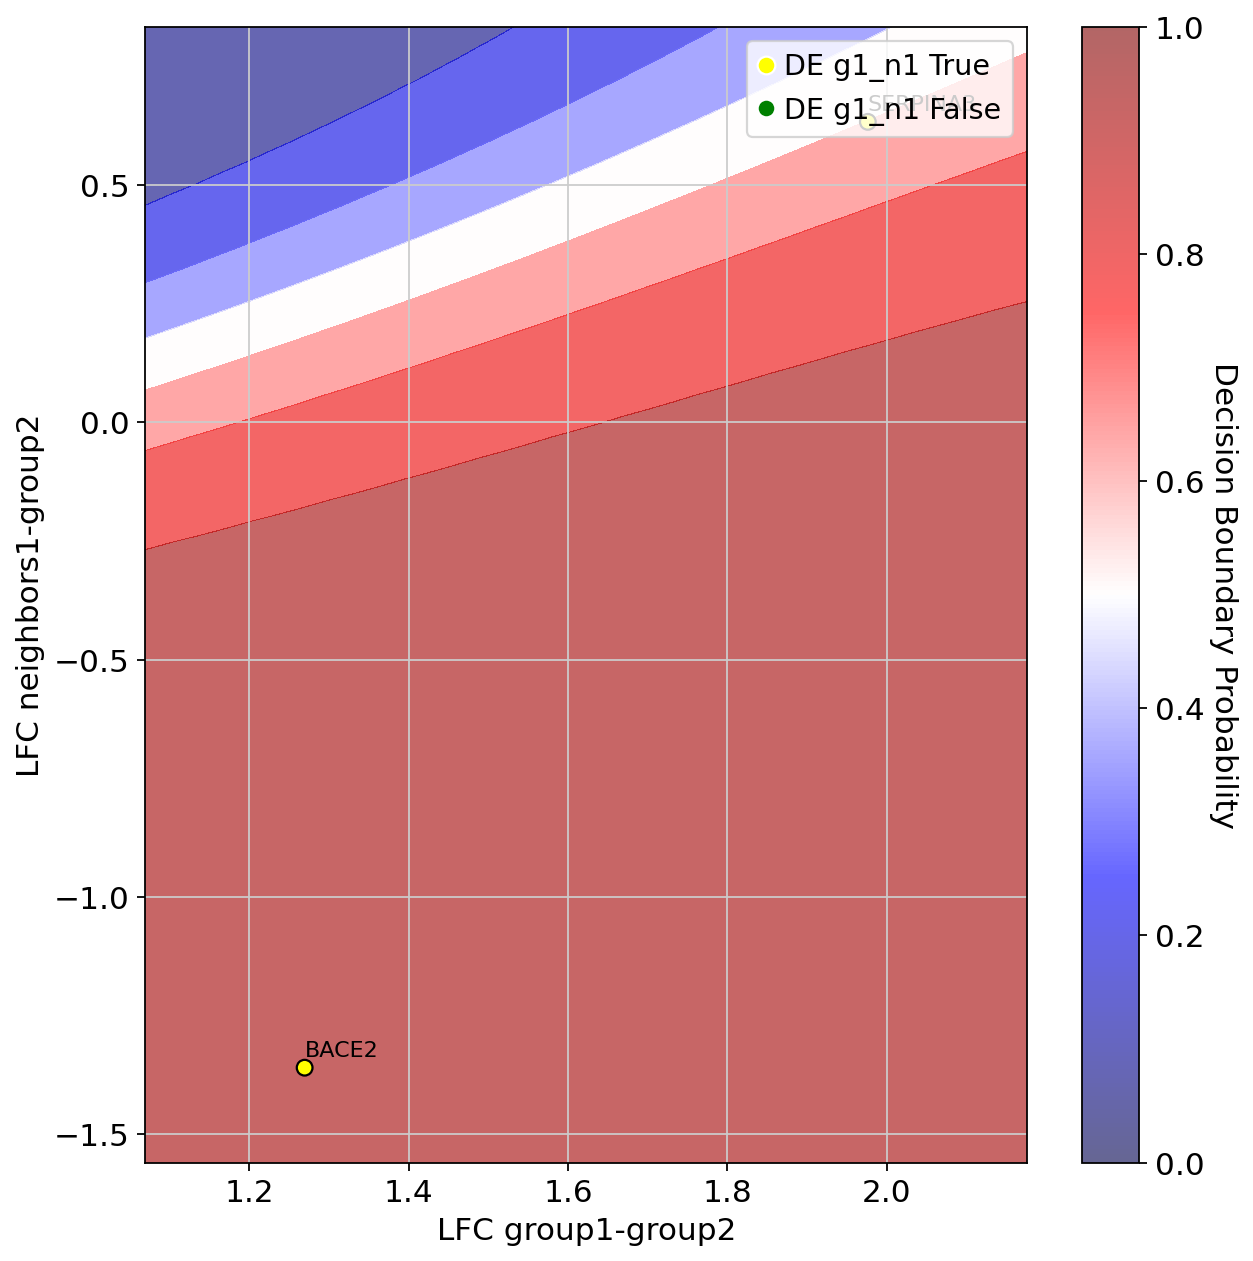

In [35]:
PLOT_MARGIN = 0.2

plot_DE_results(
    DE_1_0.gpc, #the Gaussian process classifier object
    filter=g1_g3_genes, #selected genes to plot 
    # path_to_save="DE_plot.svg",
    margin=PLOT_MARGIN, # margin around the plot
)

You can select the marker genes (positive class for the classifier, yellow in the plot):

In [36]:
DE_1_0.gpc.confident_genes

Index(['SERPINA3', 'BACE2'], dtype='object')

We can also check the predicted class probabilities of the Gaussian process classifier:

In [37]:
DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes]

SERPINA3    0.602554
BACE2       0.997595
Name: proba_de_g1_n1, dtype: float64

Then we can further filter the confident gene list, by setting a treshold on the predictions - for instance 0.9:

In [38]:
DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes][
    DE_1_0.g1_g2["proba_de_g1_n1"].loc[DE_1_0.gpc.confident_genes] > 0.9
].index

Index(['BACE2'], dtype='object')

Finally, we can plot spatial maps of the selected genes. We first compute global percentiles of the gene expression values. 

In [39]:
def get_gene_percentiles_list(adata, gene_list, p, layer=None):
    """
    Calculate the p-percentile of gene expression for a list of genes in an AnnData object.

    Parameters
    ----------
        adata (AnnData): The AnnData object containing expression data.
        gene_list (list): List of gene names for which to compute percentiles.
        p (float): Percentile to compute (between 0 and 100).
        layer (str or None): The layer from which to retrieve expression data.
                             If None, uses `adata.X`.

    Returns
    -------
        list: A list of p-percentile values for the genes, in the same order as gene_list.
              If a gene is not found, its value will be `None`.
    """
    percentiles = []

    for gene in gene_list:
        if gene in adata.var_names:
            if layer:
                data = adata[:, gene].layers[layer].flatten()
            else:
                data = adata[:, gene].X.flatten()

            # Compute the percentile
            percentiles.append(np.percentile(data, p))
        else:
            percentiles.append(None)  # Handle genes not in adata.var_names

    return percentiles

We display _ESM1_, _KDR_, _SNAI1_, critical genes for angiogenesis in invasive cancer. We aslo display _TRAF4_, that is both upregulated in $\textit{G1}$ and $\textit{N1}$, to show how our procedure can filter these genes. 

In [40]:
gene_list_invasive = ["ESM1", "KDR", "SNAI1", "TRAF4"]
percentiles_invasive = get_gene_percentiles_list(
    adata, gene_list_invasive, 99.9, layer="min_max_scaled"
)

We first plot these genes in endothelial cells:

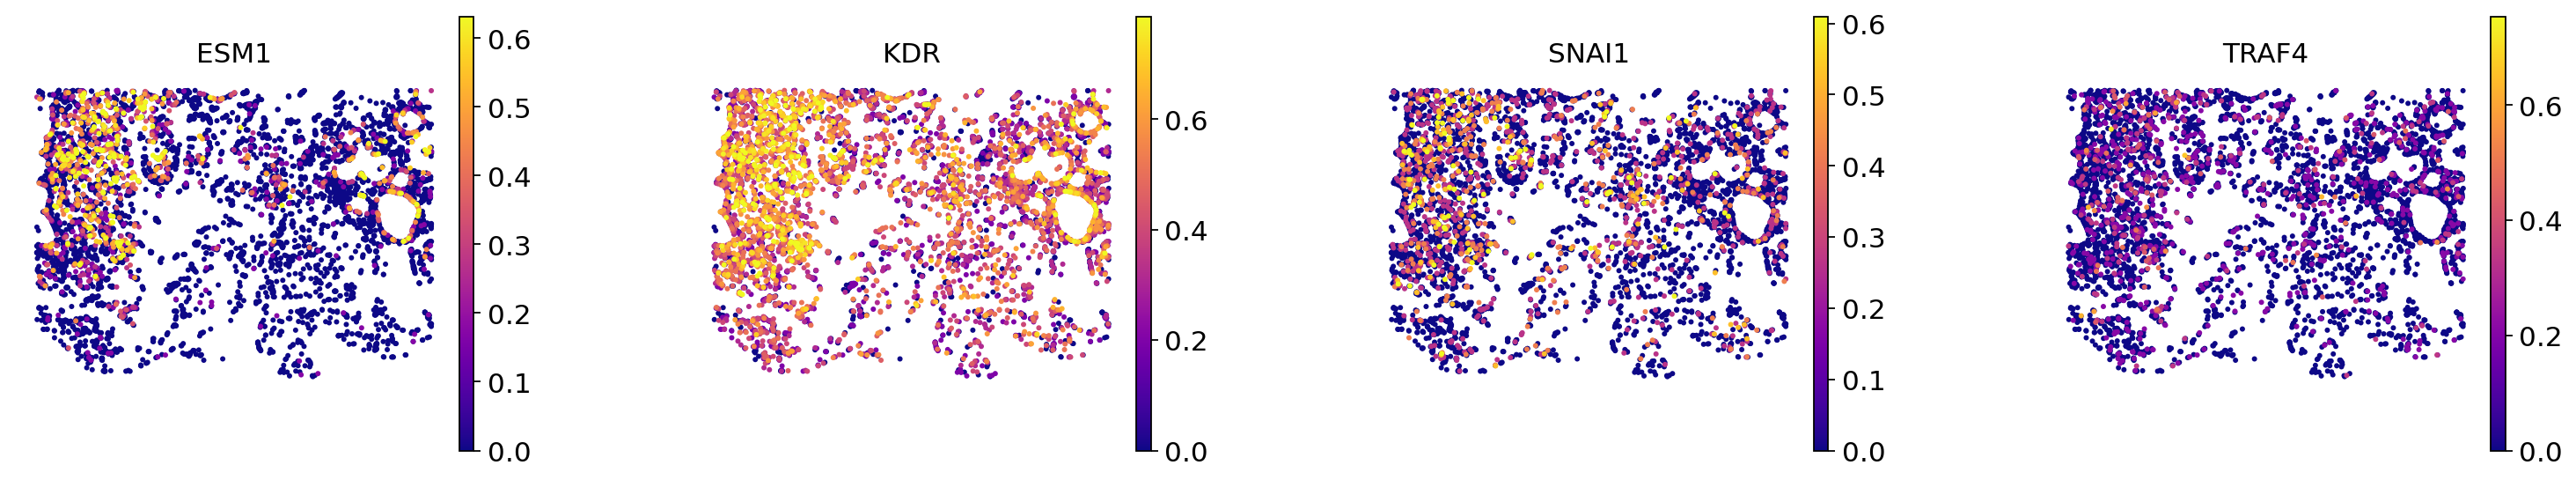

In [41]:
plot_endo = True

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    # show=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)

Then in all cells but endothelial:

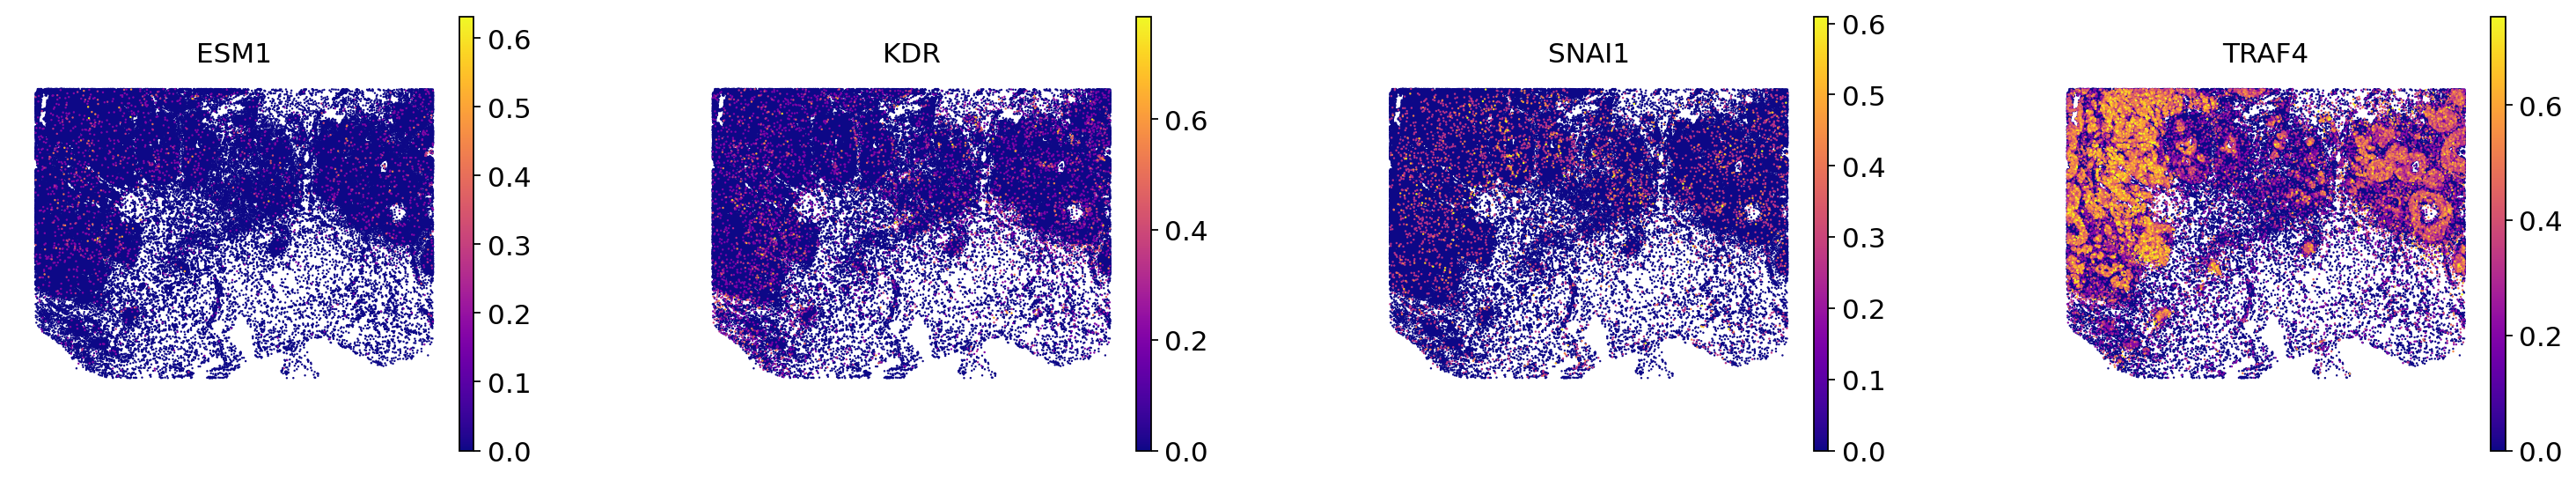

In [42]:
plot_endo = False

sc.pl.spatial(
    adata=adata_endothelial if plot_endo else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    # show=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)